In [1]:
%reset -f

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
##read excel
import pandas as pd
data_path = "/content/drive/MyDrive/prediction-divij/data-divij.xlsx"
df= pd.read_excel(data_path, engine='openpyxl')

df

,Date,Inventory
0,2023-07-03,0.00
1,2023-07-04,-5.00
2,2023-07-05,-4.80
3,2023-07-06,0.00
4,2023-07-07,19.45
...,...,...
350,2024-11-07,-32.15
351,2024-11-08,-11.05
352,2024-11-11,31.00
353,2024-11-12,13.60


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       355 non-null    datetime64[ns]
 1   Inventory  355 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.7 KB


In [4]:
# add related columns

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day_of_Month'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Inventory_is_Positive'] = df['Inventory'].apply(lambda x: 1 if x > 0 else 0)

df

,Date,Inventory,Year,Month,Day_of_Month,Day_of_Week,Day_of_Year,Inventory_is_Positive
0,2023-07-03,0.00,2023,7,3,0,184,0
1,2023-07-04,-5.00,2023,7,4,1,185,0
2,2023-07-05,-4.80,2023,7,5,2,186,0
3,2023-07-06,0.00,2023,7,6,3,187,0
4,2023-07-07,19.45,2023,7,7,4,188,1
...,...,...,...,...,...,...,...,...
350,2024-11-07,-32.15,2024,11,7,3,312,0
351,2024-11-08,-11.05,2024,11,8,4,313,0
352,2024-11-11,31.00,2024,11,11,0,316,1
353,2024-11-12,13.60,2024,11,12,1,317,1


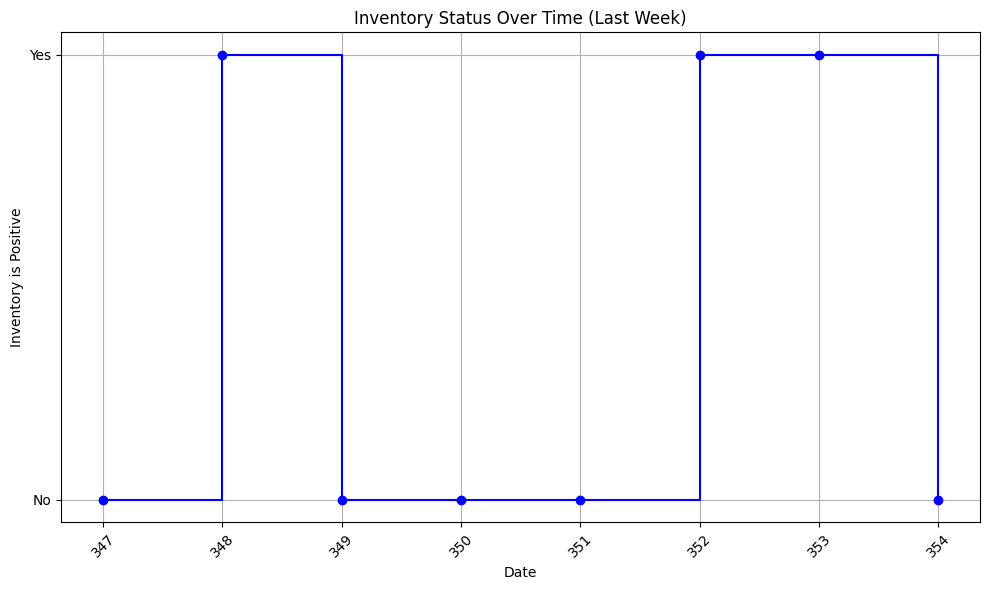

In [5]:
#plot data for last 10 days

import matplotlib.pyplot as plt

# Filter for the last week
plot_data = df[df['Date'] >= (df['Date'].max() - pd.Timedelta(days=10))]

# Plot
plt.figure(figsize=(10, 6))
plt.step(plot_data.index, plot_data['Inventory_is_Positive'], where='post', marker='o', linestyle='-', color='b')
plt.title('Inventory Status Over Time (Last Week)')
plt.xlabel('Date')
plt.ylabel('Inventory is Positive')
plt.yticks([0, 1], ['No', 'Yes'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
df.columns

Index(['Date', 'Inventory', 'Year', 'Month', 'Day_of_Month', 'Day_of_Week',
       'Day_of_Year', 'Inventory_is_Positive'],
      dtype='object')

In [30]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np



# Separate features and target
features = df.drop(columns=['Date', 'Inventory_is_Positive'])
target = features['Inventory']

# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Combine scaled features and target
scaled_data = np.hstack((scaled_features, target.values.reshape(-1, 1)))

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Short Sequences: 3, 5
# Medium Sequences: 7, 10
# Long Sequences: 14, 21
SEQ_LENGTH = 21
X, y = create_sequences(scaled_data, SEQ_LENGTH)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (334, 21, 6)
y shape: (334,)


In [37]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)




# Build the more complex LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(Dropout(0.3))  # Increase dropout to prevent overfitting
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.3))  # Increase dropout to prevent overfitting
model.add(LSTM(50))
model.add(Dropout(0.3))  # Increase dropout to prevent overfitting
model.add(Dense(50, activation='relu'))  # Add a dense layer with ReLU activation
model.add(Dense(1))  # No activation function for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])



# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the EarlyStopping callback
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {mae}')

# Make predictions
predictions = model.predict(X_test)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 119.6998 - mae: 7.9702 - val_loss: 187.5538 - val_mae: 10.1280
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 158.5867 - mae: 9.0929 - val_loss: 186.1171 - val_mae: 10.1016
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 134.0843 - mae: 8.3450 - val_loss: 184.1516 - val_mae: 10.0605
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 140.7916 - mae: 8.6005 - val_loss: 183.7308 - val_mae: 10.0545
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 117.2776 - mae: 7.9097 - val_loss: 185.8054 - val_mae: 10.0972
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 117.2282 - mae: 7.6800 - val_loss: 185.0512 - val_mae: 10.0835
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 113.8417 - mae: 7.7716 - val_loss: 186.5876 - val_mae: 10.1170
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 128.1481 - mae: 8.0877 - val_loss: 186.7869 - val_mae: 10.1224
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

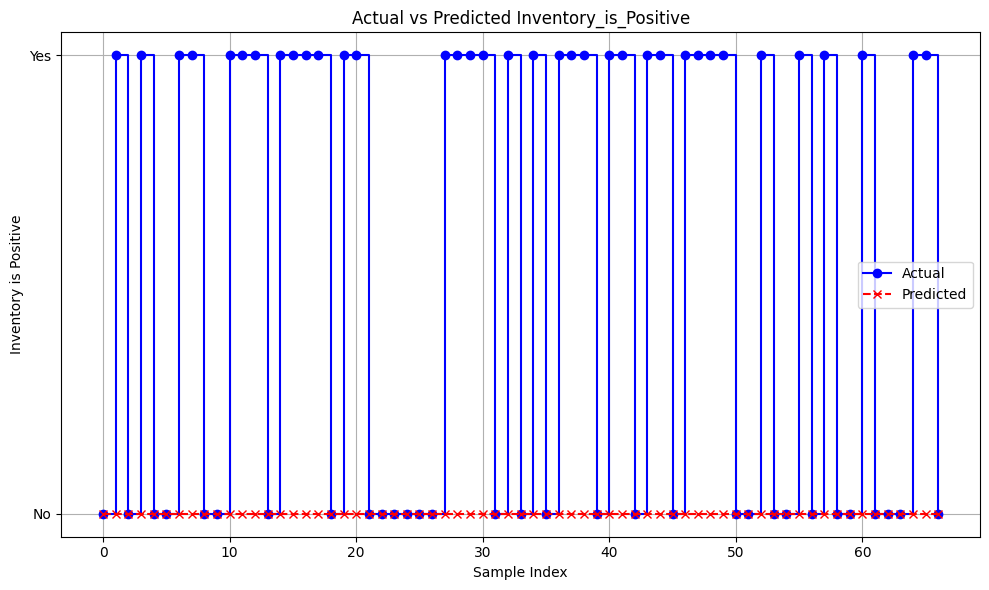

In [26]:
# Create a DataFrame for plotting


plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.flatten()
})

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.step(plot_data.index, plot_data['Actual'], where='post', marker='o', linestyle='-', color='b', label='Actual')
plt.step(plot_data.index, plot_data['Predicted'], where='post', marker='x', linestyle='--', color='r', label='Predicted')
plt.title('Actual vs Predicted Inventory_is_Positive')
plt.xlabel('Sample Index')
plt.ylabel('Inventory is Positive')
plt.yticks([0, 1], ['No', 'Yes'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()